# Linear Regression for feature ranking

In [325]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split


import os
# change to your local path to project below
project_path = '/home/jorge/Insync/jorgitoje@gmail.com/OneDrive/Documentos/JORGE/EDUCATION/MASTER_DATASCIENCE/Semester1/AdvancedStatistics/GroupProject/KDS_Statistics_GroupProject'
# TO DO:
# change code to use preprocessed dataset from Janos and Mateusz, for now I did it myself quickly
# tune lasso and ridge regression with parameters (after I have studied such in the theory)
# maybe compute iteratively to get rid of noise?

In [326]:
dataset_path = os.path.join(project_path, 'datasets/USA_houseprices_2014/data_preprocessed_FAKE.csv')
datasetname_out = 'USA_houseprices_2014' # for saving ranks lnked to that daset
feature_ranks_path = os.path.join(project_path, 'data', 'feature_ranks.csv')
df = pd.read_csv(dataset_path)

In [327]:
# Create our function which stores the feature rankings to the ranks dictionary
def ranking(ranks, names, order=1):
    minmax = MinMaxScaler()
    ranks = minmax.fit_transform(order*np.array([ranks]).T).T[0]
    ranks = map(lambda x: round(x,2), ranks)
    return dict(zip(names, ranks))

#A helper method for pretty-printing linear models
def pretty_print_linear(coefs, names = None, sort = False):
    if names == None:
        names = ["X%s" % x for x in range(len(coefs))]
    lst = zip(coefs, names)
    if sort:
        lst = sorted(lst,  key = lambda x:-np.abs(x[0]))
    return " + ".join("%s * %s" % (round(coef, 3), name)
                                   for coef, name in lst)

### Preprocessing of dataset + Preparation for model

In [328]:
df['yrs_lastmod'] = 2022 - df['last_modification']
df_regression = df.drop(['Unnamed: 0', 'date', 'street', # non informative
                        'last_modification', 'yr_built', 'yr_renovated', # replaced by 'yrs_lastmod'
                        'sqft_above' # highly correlated with sqft_living
],axis=1)
df_regression = df_regression[df_regression.price != 0]
df_regression = df_regression[df_regression.price < 0.5e7]
df_regression = df_regression[df_regression.price > 10000]
df_regression['logprice'] = np.log10(df_regression['price'])

y = df_regression['logprice']
X = df_regression.drop(['price', 'logprice'], axis = 1)

min_max_scaler = MinMaxScaler().fit(X)
X_norm = min_max_scaler.transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_norm, y, test_size = .2, random_state = 1)
features_names = X.columns

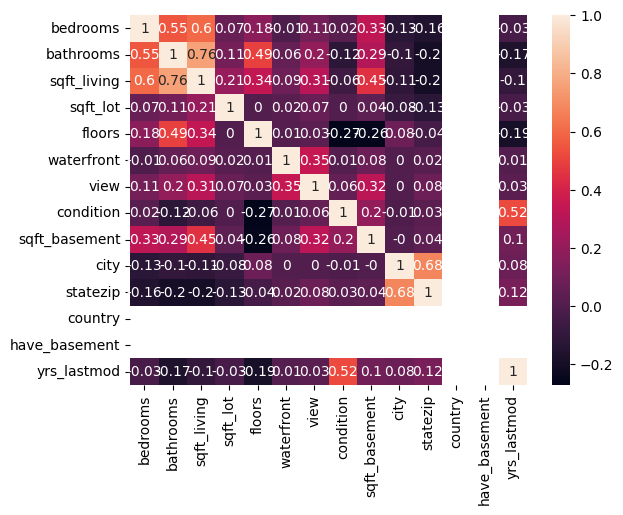

In [329]:
matrix = X.corr().round(2)
sns.heatmap(matrix, annot=True)
plt.show()

### Fitting of models

In [336]:
# Define dictionary to store our rankings
ranks = {}

lr = LinearRegression()
lr.fit(X_train,y_train)
ranks["Linear_regression"] = ranking(np.abs(lr.coef_), features_names)

print ("Linear model:", pretty_print_linear(lr.coef_))

# Using Ridge 
ridge = Ridge(alpha = 7)
ridge.fit(X_train,y_train)
ranks['Ridge_regression'] = ranking(np.abs(ridge.coef_), features_names)
print ("Ridge model:", pretty_print_linear(ridge.coef_))

# Using Lasso
lasso = Lasso(alpha=.005)
lasso.fit(X_train,y_train)
ranks["Lasso_regression"] = ranking(np.abs(lasso.coef_), features_names)
print ("Lasso model:", pretty_print_linear(lasso.coef_))

methods_names = [ key for key in ranks.keys()]

Linear model: -0.155 * X0 + 0.214 * X1 + 2.013 * X2 + -0.383 * X3 + 0.075 * X4 + 0.106 * X5 + 0.128 * X6 + 0.164 * X7 + -0.047 * X8 + 0.167 * X9 + -0.059 * X10 + 0.0 * X11 + 0.0 * X12 + 0.019 * X13
Ridge model: 0.054 * X0 + 0.405 * X1 + 0.993 * X2 + -0.014 * X3 + 0.144 * X4 + 0.088 * X5 + 0.171 * X6 + 0.133 * X7 + 0.15 * X8 + 0.163 * X9 + -0.081 * X10 + 0.0 * X11 + 0.0 * X12 + 0.022 * X13
Lasso model: 0.0 * X0 + 0.173 * X1 + 0.858 * X2 + 0.0 * X3 + 0.084 * X4 + 0.0 * X5 + 0.12 * X6 + 0.0 * X7 + 0.0 * X8 + 0.039 * X9 + -0.0 * X10 + 0.0 * X11 + 0.0 * X12 + 0.0 * X13


In [337]:
# Also RandomForest for comparison
rf = RandomForestRegressor(n_jobs=-1, n_estimators=50, verbose=3)
rf.fit(X, y)
ranks["RF_simple"] = ranking(rf.feature_importances_, features_names);

building tree 1 of 50
building tree 2 of 50
building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.1s finished


## Ranks calculation

In [338]:
decimalrank_df = pd.DataFrame()

# Join preranks in dataframe
for method_name, rank_list in ranks.items():
    df_Temp = pd.DataFrame(data = {method_name:pd.Series(rank_list)})
    decimalrank_df = pd.concat([decimalrank_df,df_Temp ], axis=1)

rank_df = pd.DataFrame()
# Create new integer ranks
for method_name, rank_list in ranks.items():
    rank_df[method_name] = decimalrank_df[method_name].rank(ascending=False)

rank_df['feature_name'] = rank_df.index
rank_df

,Linear_regression,Ridge_regression,Lasso_regression,RF_simple,feature_name
bedrooms,5.0,10.0,10.0,10.5,bedrooms
bathrooms,3.0,2.0,2.0,6.0,bathrooms
sqft_living,1.0,1.0,1.0,1.0,sqft_living
sqft_lot,2.0,12.0,10.0,4.0,sqft_lot
floors,9.0,5.5,4.0,10.5,floors
waterfront,8.0,8.0,10.0,13.0,waterfront
view,7.0,3.0,3.0,7.5,view
condition,5.0,7.0,10.0,9.0,condition
sqft_basement,11.0,5.5,10.0,7.5,sqft_basement
city,5.0,4.0,5.0,3.0,city


In [339]:
# Save results
ranksout = rank_df.melt(id_vars = 'feature_name', var_name='method', value_name='feature_rank')
ranksout['dataset'] = datasetname_out
ranksout = ranksout[ranksout['method'].isin(methods_names)]
ranksout.to_csv(os.path.join(project_path, 'data', 'featureranks_linear.csv'), sep=";", index=False)